# Integrate resources to replicate hetionet (AlzKB)

In [1]:
#pip install hetio

In [2]:
# add rel used in alzkb even we didn't update this time
# add scores to rel

In [3]:
import pandas
import seaborn

import hetio.hetnet
import hetio.readwrite
import hetio.stats

#from utils import rawgit, obo_iri
def obo_iri(identifier):
    return 'http://purl.obolibrary.org/obo/' + identifier.replace(':', '_')

/opt/anaconda3/lib/python3.9/site-packages/hetio/__init__.py:11: FutureWarning: 
PACKAGE HAS BEEN RELOCATED:
v0.2.11 is the last release before the hetio package is renamed to hetnetpy.
Consider switching to the hetnetpy package or specifying hetio<=0.2.10 to silence this warning.
Future releases and development will only occur for the hetnetpy package.

  warnings.warn(message, FutureWarning)


In [4]:
#function
def rawgit(handle, repo, commit, *args):
    """Returns url for a raw file in a github reposotory."""
    url_head = 'https://raw.githubusercontent.com'
    return '/'.join((url_head, handle, repo, commit) + args)

## Define the metagraph and instantiate the graph

In [5]:
kind_to_abbev = {
    
    # metanodes
    'Compound': 'C',
    'Disease': 'D',
    'Gene': 'G',
    'Anatomy': 'A',
    'Symptom': 'S',
    'Side Effect': 'SE',
    #'Pathway': 'PW',
    'Pharmacologic Class': 'PC',
    'Biological Process': 'BP',
    'Cellular Component': 'CC',
    'Molecular Function': 'MF',
    
    # metaedges
    'treats': 't',
    'palliates': 'p',
    'binds': 'b',
    'expresses': 'e',
    'regulates': 'r',
    'upregulates': 'u',
    'downregulates': 'd',
    'interacts': 'i',
    'includes': 'i',
    'covaries': 'c',
    'regulates': 'r',
    'participates': 'p',
    'resembles': 'r',
    'associates': 'a',
    'localizes': 'l',
    'presents': 'p',
    'causes': 'c',
}

metaedge_tuples = [ #only those we're updating this time
    ('Compound', 'Disease', 'treats', 'both'),
    ('Compound', 'Disease', 'palliates', 'both'),
    ('Compound', 'Gene', 'binds', 'both'),
    ('Compound', 'Gene', 'upregulates', 'both'),
    ('Compound', 'Gene', 'downregulates', 'both'),
    #('Compound', 'Compound', 'resembles', 'both'),
    ('Compound', 'Side Effect', 'causes', 'both'),
    ('Pharmacologic Class', 'Compound', 'includes', 'both'),
    #('Anatomy', 'Gene', 'expresses', 'both'),
    ('Anatomy', 'Gene', 'upregulates', 'both'),
    ('Anatomy', 'Gene', 'downregulates', 'both'),
    ('Gene', 'Gene', 'interacts', 'both'),
    ('Gene', 'Gene', 'covaries', 'both'),
    ('Gene', 'Gene', 'regulates', 'forward'),
    #('Gene', 'Pathway', 'participates', 'both'),
    ('Gene', 'Biological Process', 'participates', 'both'),
    ('Gene', 'Cellular Component', 'participates', 'both'),
    ('Gene', 'Molecular Function', 'participates', 'both'),
    ('Disease', 'Disease', 'resembles', 'both'),
    #('Disease', 'Gene', 'associates', 'both'),
    #('Disease', 'Gene', 'upregulates', 'both'),
    #('Disease', 'Gene', 'downregulates', 'both'),
    ('Disease', 'Anatomy', 'localizes', 'both'),
    ('Disease', 'Symptom', 'presents', 'both'),
]
metagraph = hetio.hetnet.MetaGraph.from_edge_tuples(metaedge_tuples, kind_to_abbev)
graph = hetio.hetnet.Graph(metagraph)

In [6]:
import os
path ='../data'

## Gene Nodes

In [7]:
url = os.path.join(path, 'EntrezGene/genes-human.tsv')
gene_df = pandas.read_table(url)
gene_df = gene_df[gene_df.type_of_gene == 'protein-coding']
coding_genes = set(gene_df.GeneID)
gene_df.head(2)

,tax_id,GeneID,Symbol,chromosome,map_location,type_of_gene,description
0,9606,1,A1BG,19,19q13.43,protein-coding,alpha-1-B glycoprotein
1,9606,2,A2M,12,12p13.31,protein-coding,alpha-2-macroglobulin


In [8]:
for i, row in gene_df.iterrows():
    if row.type_of_gene != 'protein-coding':
        continue
    data = {
        'description': row['description'],
        'source': 'Entrez Gene',
        'url': 'http://identifiers.org/ncbigene/{}'.format(row.GeneID),
        'license': 'CC0 1.0',
    }
    if pandas.notnull(row['chromosome']):
        data['chromosome'] = row['chromosome']
    graph.add_node(kind = 'Gene', identifier=row.GeneID, name=row.Symbol, data=data)

## Disease Nodes

In [9]:
url = os.path.join(path, 'DiseaseOntology/slim-terms.tsv')
disease_df = pandas.read_table(url)
disease_df.head(2)

,doid,name,source,pathophysiology
0,DOID:2531,hematologic cancer,DOcancerslim,neoplastic
1,DOID:1319,brain cancer,DOcancerslim,neoplastic


In [10]:
for i, row in disease_df.iterrows():
    data = {
        'source': 'Disease Ontology',
        'url': obo_iri(row.doid),
        'license': 'CC BY 3.0',
    }
    graph.add_node(kind='Disease', identifier=row.doid, name=row['name'], data=data)

## Compound Nodes

In [11]:
url = os.path.join(path, 'DrugBank/drugbank-slim.tsv')
compound_df = pandas.read_table(url)
compound_df.head(2)

,drugbank_id,name,type,groups,atc_codes,categories,inchikey,inchi,description
0,DB00006,Bivalirudin,small molecule,approved|investigational,B01AE06,"Amino Acids, Peptides, and Proteins|Anticoagul...",OIRCOABEOLEUMC-GEJPAHFPSA-N,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,Bivalirudin is a synthetic 20 residue peptide ...
1,DB00007,Leuprolide,small molecule,approved|investigational,L02AE51|L02AE02,Adrenal Cortex Hormones|Agents Causing Muscle ...,GFIJNRVAKGFPGQ-LIJARHBVSA-N,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,Leuprolide is a synthetic 9-residue peptide an...


In [12]:
for i, row in compound_df.iterrows():
    url = 'http://www.drugbank.ca/drugs/' + row.drugbank_id
    data = {
        'source': 'DrugBank',
        'inchikey': row.inchikey,
        'inchi': row.inchi, 'url': url,
        'license': 'CC BY-NC 4.0',
    }
    graph.add_node(kind='Compound', identifier=row.drugbank_id, name=row['name'], data=data)

## Anotomy nodes

In [13]:
url = os.path.join(path, 'Uberon/hetio-slim.tsv')
uberon_df = pandas.read_table(url)
uberon_df.head(2)

,uberon_id,uberon_name,mesh_id,mesh_name,bto_id
0,UBERON:0000002,uterine cervix,D002584,Cervix Uteri,BTO:0001421
1,UBERON:0000004,nose,D009666,Nose,BTO:0000840


In [14]:
for i, row in uberon_df.iterrows():
    data = {
        'source': 'Uberon',
        'url': obo_iri(row['uberon_id']),
        'license': 'CC BY 3.0',
    }
    for xref in 'mesh_id', 'bto_id':
        if pandas.notnull(row[xref]):
            data[xref] = row[xref]
    graph.add_node(kind='Anatomy', identifier=row['uberon_id'], name=row['uberon_name'], data=data)

## Symptom Nodes

In [15]:
url = os.path.join(path, 'MeSH/symptoms.tsv')
symptom_df = pandas.read_table(url)
symptom_df.head(2)

,mesh_id,mesh_name,in_hsdn
0,D000006,"Abdomen, Acute",1
1,D000067329,"Obesity, Metabolically Benign",0


In [16]:
for i, row in symptom_df.iterrows():
    url = 'http://identifiers.org/mesh/{}'.format(row.mesh_id)
    data = {
        'source': 'MeSH',
        'url': url,
        'license': 'CC0 1.0',
    }
    graph.add_node(kind='Symptom', identifier=row.mesh_id, name=row.mesh_name, data=data)

## Pharmacologic Classes

In [17]:
url = os.path.join(path, 'DrugCentral/classes.tsv')
class_df = pandas.read_table(url)
class_types = {'Physiologic Effect', 'Mechanism of Action', 'Chemical/Ingredient', 'Chemical Structure'}
class_df = class_df.query("class_type in @class_types")
class_df.head(2)

,class_id,class_name,class_source,class_type,url
639,M0000499,Adrenocorticotropic Hormone,FDA,Chemical Structure,http://purl.bioontology.org/ontology/NDFRT/M00...
640,M0000713,Alkaloids,FDA,Chemical Structure,http://purl.bioontology.org/ontology/NDFRT/M00...


In [18]:
for row in class_df.itertuples():
    data = {
        'source': '{} via DrugCentral'.format(row.class_source),
        'class_type': row.class_type,
        'license': 'CC BY 4.0',
        'url': row.url,
    }
    graph.add_node(kind='Pharmacologic Class', identifier=row.class_id, name=row.class_name, data=data)

In [19]:
url = os.path.join(path, 'DrugCentral/drug-to-class.tsv')
drug_class_df = pandas.read_table(url)
drug_class_df = drug_class_df.query("class_id in @class_df.class_id")
drug_class_df.head(2)

,drugbank_id,drugbank_name,class_id,class_name
1,DB11791,Capmatinib,N0000182138,Cytochrome P450 1A2 Inhibitors
2,DB11791,Capmatinib,N0000185503,P-Glycoprotein Inhibitors


In [20]:
for row in drug_class_df.itertuples():
    data = {
        'source': 'DrugCentral',
        'license': 'CC BY 4.0',
        'unbiased': False,
    }
    source_id = 'Pharmacologic Class', row.class_id
    target_id = 'Compound', row.drugbank_id
    graph.add_edge(source_id, target_id, 'includes', 'both', data)

## Gene Ontology Domains

In [21]:
url = os.path.join(path, 'GeneOntology/GO_annotations-9606-inferred-allev.tsv')
go_df = pandas.read_table(url)
go_df.head(2)

,go_id,go_name,go_domain,tax_id,annotation_type,size,gene_ids,gene_symbols
0,GO:0000002,mitochondrial genome maintenance,biological_process,9606,inferred,26,142|291|1763|1890|2021|4205|4358|4976|5428|624...,PARP1|SLC25A4|DNA2|TYMP|ENDOG|MEF2A|MPV17|OPA1...
1,GO:0000009,"alpha-1,6-mannosyltransferase activity",molecular_function,9606,inferred,2,55650|79087,PIGV|ALG12


In [22]:
for i, row in go_df.iterrows():
    genes = coding_genes & set(map(int, row.gene_ids.split('|')))
    if 2 > len(genes) or len(genes) > 1000:
        continue
    kind = row['go_domain'].replace('_', ' ').title()
    data = {'source': 'Gene Ontology', 'url': obo_iri(row.go_id), 'license': 'CC BY 4.0'}
    target = graph.add_node(kind=kind, identifier=row['go_id'], name=row['go_name'], data=data)
    target_id = target.get_id()
    for gene in genes:
        source_id = 'Gene', gene
        data = {'source': 'NCBI gene2go', 'unbiased': False, 'license': 'CC BY 4.0'}
        graph.add_edge(source_id, target_id, 'participates', 'both', data)

## MEDLINE cooccurrence data

In [23]:
medline_data = {
    'source': 'MEDLINE cooccurrence',
    'unbiased': False,
    'license': 'CC0 1.0',
}

### Symptom edges

In [24]:
url = os.path.join(path, 'MEDLINE/disease-symptom-cooccurrence.tsv')
disease_symptom_df = pandas.read_table(url)
disease_symptom_df = disease_symptom_df[disease_symptom_df.p_fisher < 0.005]
disease_symptom_df.head(2)

,doid_code,doid_name,mesh_id,mesh_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher,n_source,n_target
0,DOID:10652,Alzheimer's disease,D000647,Amnesia,489,19.641482,24.896288,48.294582,0.0,10199,1042
1,DOID:10652,Alzheimer's disease,D004314,Down Syndrome,1102,56.021580,19.670991,34.268557,0.0,10199,2972


In [25]:
for i, row in disease_symptom_df.iterrows():
    source_id = 'Disease', row.doid_code
    target_id = 'Symptom', row.mesh_id
    data = medline_data.copy()
    data['p_fisher'] = row.p_fisher
    graph.add_edge(source_id, target_id, 'presents', 'both', data)

### Disease-localization edges

In [26]:
url = os.path.join(path, 'MEDLINE/disease-uberon-cooccurrence.tsv')
disease_anatomy_df = pandas.read_table(url)
disease_anatomy_df = disease_anatomy_df[disease_anatomy_df.p_fisher < 0.005]
disease_anatomy_df = disease_anatomy_df[disease_anatomy_df.uberon_id.isin(uberon_df['uberon_id'])]
disease_anatomy_df.head(2)

,doid_code,doid_name,uberon_id,uberon_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher,n_source,n_target
0,DOID:10652,Alzheimer's disease,UBERON:0000955,brain,21745,3071.649615,7.079258,27.695942,0.0,30744,97944
1,DOID:10652,Alzheimer's disease,UBERON:0000956,cerebral cortex,3590,594.986283,6.033753,8.029408,0.0,30744,18972


In [27]:
for i, row in disease_anatomy_df.iterrows():
    source_id = 'Disease', row.doid_code
    target_id = 'Anatomy', row.uberon_id
    data = medline_data.copy()
    data['p_fisher'] = row.p_fisher
    graph.add_edge(source_id, target_id, 'localizes', 'both', data)

### Disease-disease similarity

In [28]:
url = os.path.join(path, 'MEDLINE/disease-disease-cooccurrence.tsv')
disease_similarity_df = pandas.read_table(url)
disease_similarity_df = disease_similarity_df[-disease_similarity_df[['doid_code_0', 'doid_code_1']].apply(frozenset, 1).duplicated()]
disease_similarity_df = disease_similarity_df[disease_similarity_df.p_fisher < 0.005]
disease_similarity_df.head(2)

,doid_code_0,doid_name_0,doid_code_1,doid_name_1,cooccurrence,expected,enrichment,odds_ratio,p_fisher,n_source,n_target
0,DOID:10652,Alzheimer's disease,DOID:14330,Parkinson's disease,2521,1562.065225,1.613889,1.651428,8.873145e-115,104084,73639
1,DOID:10652,Alzheimer's disease,DOID:11949,Creutzfeldt-Jakob disease,157,116.223134,1.350850,1.361746,1.558560e-04,104084,5479


In [29]:
disease_similarity_df[disease_similarity_df['doid_name_0']=="Alzheimer's disease"]

,doid_code_0,doid_name_0,doid_code_1,doid_name_1,cooccurrence,expected,enrichment,odds_ratio,p_fisher,n_source,n_target
0,DOID:10652,Alzheimer's disease,DOID:14330,Parkinson's disease,2521,1562.065225,1.613889,1.651428,8.873145e-115,104084,73639
1,DOID:10652,Alzheimer's disease,DOID:11949,Creutzfeldt-Jakob disease,157,116.223134,1.350850,1.361746,1.558560e-04,104084,5479


In [30]:
for i, row in disease_similarity_df.iterrows():
    source_id = 'Disease', row.doid_code_0
    target_id = 'Disease', row.doid_code_1
    data = medline_data.copy()
    data['p_fisher'] = row.p_fisher
    graph.add_edge(source_id, target_id, 'resembles', 'both', data)

## Anatomy-gene differential expression

In [31]:
commit = '08ba54e83ee8e28dec22b4351d29e23f1d034d30'
url = rawgit('dhimmel', 'bgee', commit, 'data/diffex.tsv.gz')
diffex_df = pandas.read_table(url, compression='gzip')
diffex_df = pandas.melt(diffex_df, id_vars='GeneID', var_name='uberon_id', value_name='direction')
diffex_df = diffex_df.query("direction != 0")
diffex_df = diffex_df[diffex_df.uberon_id.isin(uberon_df.uberon_id) & diffex_df.GeneID.isin(coding_genes)]
diffex_df = diffex_df.replace({'direction': {-1: 'downregulates', 1: 'upregulates'}})
diffex_df.head(2)

,GeneID,uberon_id,direction
37241,2,UBERON:0000002,upregulates
37249,18,UBERON:0000002,downregulates


In [32]:
for i, row in diffex_df.iterrows():
    source_id = 'Gene', row['GeneID']
    target_id = 'Anatomy', row['uberon_id']
    data = {'source': 'Bgee', 'unbiased': True}
    graph.add_edge(source_id, target_id, row['direction'], 'both', data)

## Compound bindings

In [33]:
url = os.path.join(path, 'BindingDB/CbG-binding.tsv')
binding_df = pandas.read_table(url)
binding_df = binding_df.merge(compound_df[['drugbank_id']])
binding_df = binding_df[binding_df.entrez_gene_id.isin(coding_genes)]
binding_df.head(2)

,drugbank_id,entrez_gene_id,sources,pubmed_ids,actions,affinity_nM,license,urls
0,DB00006,2147,DrugBank (target)|DrugCentral (IUPHAR),11060732|11504570|11752352|11833835|11923794|1...,inhibitor,NaN,CC BY-NC 4.0,NaN
1,DB00006,4353,DrugBank (enzyme),18701766,inhibitor,NaN,CC BY-NC 4.0,NaN


In [34]:
for i, row in binding_df.iterrows():
    source_id = 'Compound', row.drugbank_id
    target_id = 'Gene', row.entrez_gene_id
    data = {'unbiased': False}
    # singular fields
    for key in 'affinity_nM', 'license':
        value = row[key]
        if pandas.notnull(value):
            data[key] = value
    # compound fields
    for key in 'sources', 'pubmed_ids', 'actions', 'urls':
        value = row[key]
        if pandas.notnull(value):
            data[key] = value.split('|')
    data['source'] = row['sources']
    graph.add_edge(source_id, target_id, 'binds', 'both', data)

## Protein Interactions

In [35]:
commit = 'f6a7edbc8de6ba2d7fe1ef3fee4d89e5b8d0b900'
url = rawgit('dhimmel', 'ppi', commit, 'data/ppi-hetio-ind.tsv')
ppi_df = pandas.read_table(url)
ppi_df = ppi_df[ppi_df.gene_0.isin(coding_genes) & ppi_df.gene_1.isin(coding_genes)]
# Consider allowing self-interactions in future versions of Hetionet by removing following 
# line of code. See https://github.com/dhimmel/hetio/issues/10
ppi_df = ppi_df.query("gene_0 != gene_1")
ppi_df.head(2)

,gene_0,gene_1,sources,unbiased
0,1,310,hetio-dag,0
1,1,1026,hetio-dag,0


In [36]:
for i, row in ppi_df.iterrows():
    source_id = 'Gene', row.gene_0
    target_id = 'Gene', row.gene_1
    data = {
        'sources': row.sources.split('|'),
        'unbiased': bool(row.unbiased),
    }
    data['source'] = 'Hetionet - '+row.sources
    graph.add_edge(source_id, target_id, 'interacts', 'both', data)

## Evolutionary rate covariation

In [37]:
commit = '757733f77a89499439c887acb88456e011c5322e'
url = rawgit('dhimmel', 'erc', commit, 'data/erc_mam33-entrez-gt-0.6.tsv.gz')
erc_df = pandas.read_table(url, compression='gzip')
erc_df = erc_df[erc_df.correlation >= 0.75]
erc_df = erc_df[erc_df.source_entrez.isin(coding_genes) & erc_df.target_entrez.isin(coding_genes)]
# Drop self-loops (see https://github.com/dhimmel/erc/issues/2)
erc_df = erc_df.query("source_entrez != target_entrez")
# Drop duplicate gene pair(s) (see https://github.com/dhimmel/erc/issues/1)
erc_df['gene_pair'] = list(map(frozenset, zip(erc_df.source_entrez, erc_df.target_entrez)))
erc_df = erc_df.drop_duplicates('gene_pair', keep='last')
erc_df.head(2)

,source_entrez,target_entrez,correlation,n_ucsc_genes,gene_pair
29,9,3295,0.77623,1,"(9, 3295)"
46,9,23313,0.79472,1,"(9, 23313)"


In [38]:
for i, row in erc_df.iterrows():
    source_id = 'Gene', row.source_entrez
    target_id = 'Gene', row.target_entrez
    data = {
        'source': 'Hetionet - ERC',
        'unbiased': True,
    }
    data['correlation']=row.correlation
    graph.add_edge(source_id, target_id, 'covaries', 'both', data)

## Indications from the PharmacotherapyDB

In [39]:
commit = '11d535ba0884ee56c3cd5756fdfb4985f313bd80'
url = rawgit('dhimmel', 'indications', commit, 'catalog/indications.tsv')
indication_df = pandas.read_table(url)
categories = {'DM', 'SYM'}
indication_df = indication_df.query("category in @categories").copy()
indication_df['kind'] = indication_df.category.map({'DM': 'treats', 'SYM': 'palliates'})
indication_df.head(2)

,doid_id,drugbank_id,disease,drug,category,n_curators,n_resources,kind
0,DOID:10652,DB00843,Alzheimer's disease,Donepezil,DM,2,1,treats
1,DOID:10652,DB00674,Alzheimer's disease,Galantamine,DM,1,4,treats


In [40]:
indication_df.shape

(1145, 8)

In [41]:
indication_df=indication_df[indication_df['drugbank_id'].isin(compound_df['drugbank_id'].to_list())]
indication_df.shape

(1129, 8)

In [42]:
for i, row in indication_df.iterrows():
    source_id = 'Disease', row.doid_id
    target_id = 'Compound', row.drugbank_id
    data = {'source': 'Hetionet - PharmacotherapyDB', 'unbiased': False, 'license': 'CC0 1.0'}
    graph.add_edge(source_id, target_id, row['kind'], 'both', data)

## LINCS L1000 relationships

In [43]:
commit = 'abcb12f942f93e3ee839e5e3593f930df2c56845'

In [44]:
def filter_l1000_df(df, n):
    """
    Filter LINCS L1000 differentially expression genes to at most `n` genes
    per perturbagen-direction-status combination.
    """
    df = df.groupby(['perturbagen', 'direction', 'status']).apply(
        lambda x: x.nlargest(n, 'nlog10_bonferroni_pval')).reset_index(drop=True)
    return df

### LINCS compound-gene dysregulation

In [45]:
url = rawgit('dhimmel', 'lincs', commit, 'data/consensi/signif/dysreg-drugbank.tsv')
l1000_df = pandas.read_table(url)
l1000_df = l1000_df.query("perturbagen in @compound_df.drugbank_id and entrez_gene_id in @coding_genes")
l1000_df = filter_l1000_df(l1000_df, n=125)
l1000_df.tail(2)

,perturbagen,entrez_gene_id,z_score,symbol,status,direction,nlog10_bonferroni_pval
40550,DB09020,3895,4.077,KTN1,measured,up,1.351
40551,DB09020,23368,4.062,PPP1R13B,measured,up,1.323


In [46]:
mapper = {'up': 'upregulates', 'down': 'downregulates'}
for row in l1000_df.itertuples():
    source_id = 'Compound', row.perturbagen
    target_id = 'Gene', row.entrez_gene_id
    data = {
        'source': 'Hetionet - LINCS L1000',
        'z_score': round(row.z_score, 3),
        'method': row.status,
        'unbiased': True,
    }
    kind = mapper[row.direction]
    graph.add_edge(source_id, target_id, kind, 'both', data)

### LINCS genetic perturbations

In [47]:
url = rawgit('dhimmel', 'lincs', commit, 'data/consensi/signif/dysreg-knockdown.tsv')
l1000_kd_df = filter_l1000_df(pandas.read_table(url), n=50)

url = rawgit('dhimmel', 'lincs', commit, 'data/consensi/signif/dysreg-overexpression.tsv')
l1000_oe_df = filter_l1000_df(pandas.read_table(url), n=50)

In [48]:
mapper = {'up': 'knockdown upregulates', 'down': 'knockdown downregulates'}
l1000_kd_df['kind'] = l1000_kd_df.direction.map(lambda x: mapper[x])

mapper = {'up': 'overexpression upregulates', 'down': 'overexpression downregulates'}
l1000_oe_df['kind'] = l1000_oe_df.direction.map(lambda x: mapper[x])

l1000_genetic_df = pandas.concat([l1000_kd_df, l1000_oe_df])
l1000_genetic_df = l1000_genetic_df.query('perturbagen in @coding_genes and entrez_gene_id in @coding_genes')
l1000_genetic_df = l1000_genetic_df.query('perturbagen != entrez_gene_id')

l1000_genetic_df.head(2)

,perturbagen,entrez_gene_id,z_score,symbol,status,direction,nlog10_bonferroni_pval,kind
0,2,7422,-7.823,VEGFA,imputed,down,10.475,knockdown downregulates
1,2,6382,-6.402,SDC1,imputed,down,6.002,knockdown downregulates


In [49]:
for (pert, gene), df in l1000_genetic_df.groupby(['perturbagen', 'entrez_gene_id'], sort=False):
    source_id = 'Gene', pert
    target_id = 'Gene', gene
    method, = df.status.unique()
    data = {'source': 'Hetionet - LINCS L1000', 'subtypes': list(df.kind), 'method': method, 'unbiased': True}
    data['z_score']=df.loc[df.index[0], 'z_score']
    graph.add_edge(source_id, target_id, 'regulates', 'forward', data)

## Side Effects - SIDER

In [50]:
commit = 'be3adebc0d845baaddb907a880890cb5e85f5801'
url = rawgit('dhimmel', 'SIDER4', commit, 'data/side-effect-terms.tsv')
side_effect_df = pandas.read_table(url)
side_effect_df.head(2)

,umls_cui_from_meddra,side_effect_name
0,C0863129,AGEP
1,C0001849,AIDS dementia complex


In [51]:
for i, row in side_effect_df.iterrows():
    umls_id = row['umls_cui_from_meddra']
    data = {
        'source': 'Hetionet - UMLS via SIDER 4.1',
        'url': 'http://identifiers.org/umls/{}'.format(umls_id),
        'license': 'CC BY-NC-SA 4.0',
    }
    graph.add_node(kind='Side Effect', identifier=umls_id, name=row['side_effect_name'], data=data)

In [52]:
url = rawgit('dhimmel', 'SIDER4', commit, 'data/side-effects.tsv')
sider_df = pandas.read_table(url)
sider_df = sider_df[sider_df.drugbank_id.isin(compound_df.drugbank_id)]
sider_df.head(2)

,drugbank_id,drugbank_name,umls_cui_from_meddra,side_effect_name
6398,DB01048,Abacavir,C0001849,AIDS dementia complex
6399,DB01048,Abacavir,C0232487,Abdominal discomfort


In [53]:
for i, row in sider_df.iterrows():
    umls_id = row.umls_cui_from_meddra
    source_id = 'Compound', row.drugbank_id
    target_id = 'Side Effect', umls_id
    data = {
        'source': 'Hetionet - SIDER 4.1',
        'url': 'http://sideeffects.embl.de/se/{}/'.format(umls_id),
        'unbiased': False,
        'license': 'CC BY-NC-SA 4.0',
    }
    graph.add_edge(source_id, target_id, 'causes', 'both', data)

## Network visualizations and stats

In [60]:
# Export node degree tables
hetio.stats.degrees_to_excel(graph, os.path.join(path,'hetionet-custom-degrees.xlsx'))

/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot`

/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

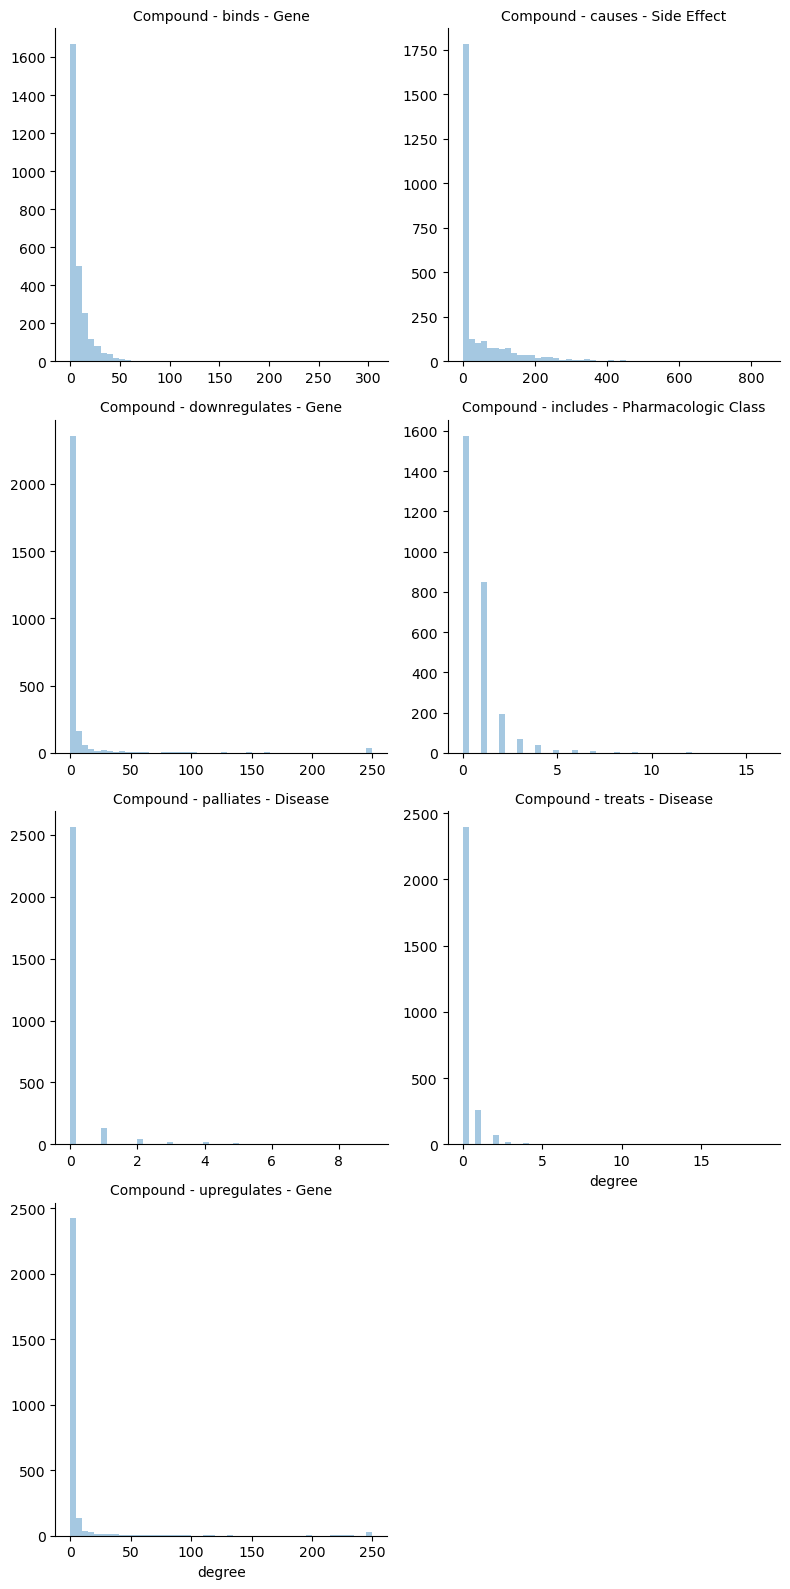

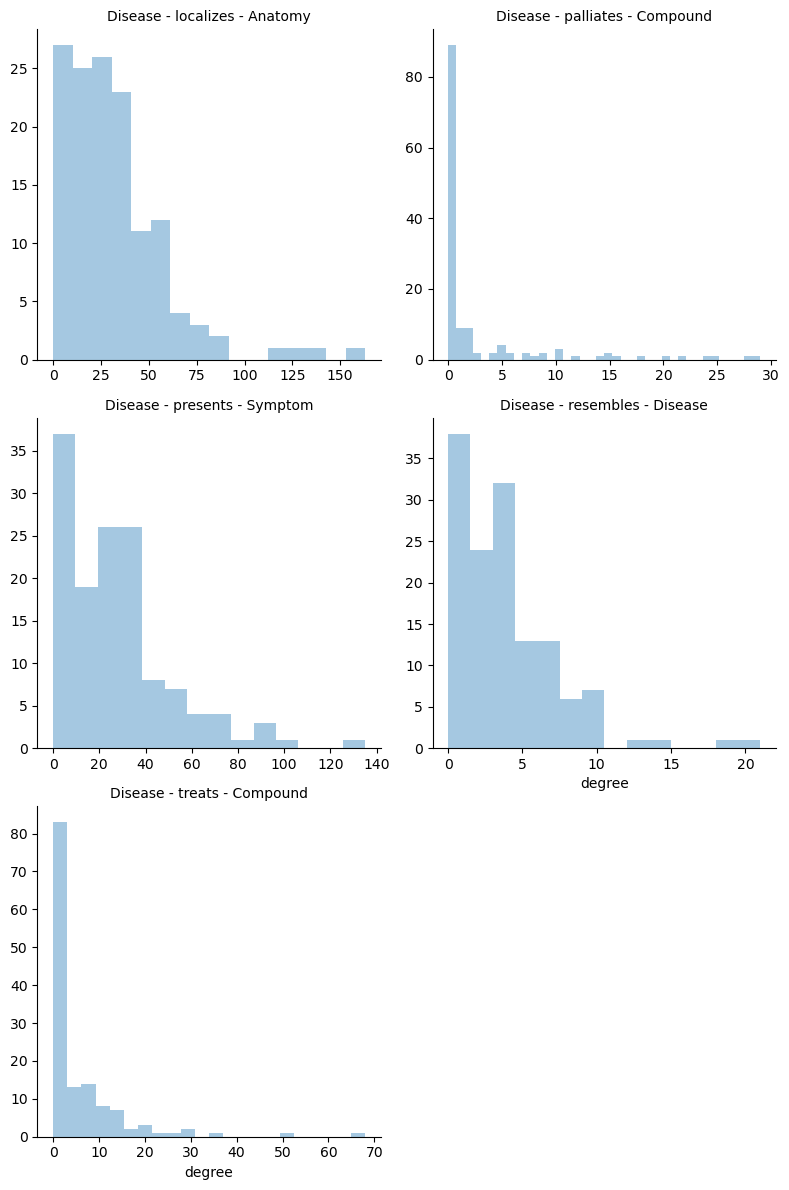

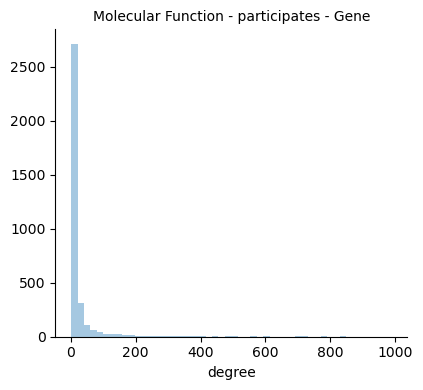

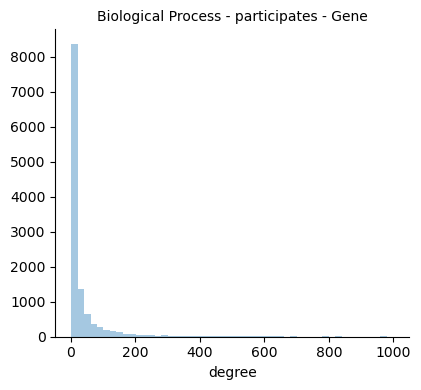

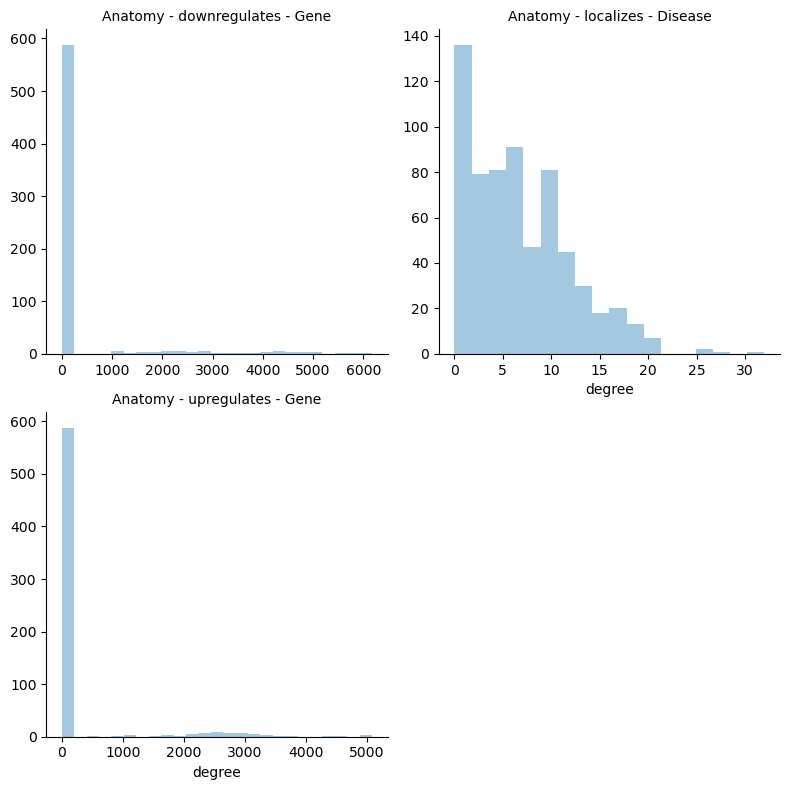

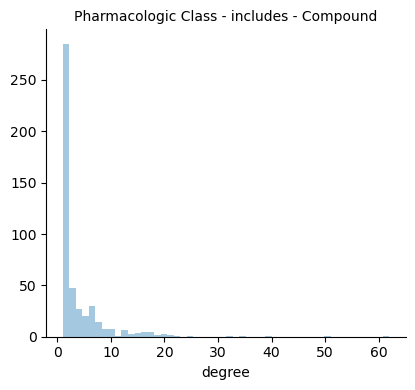

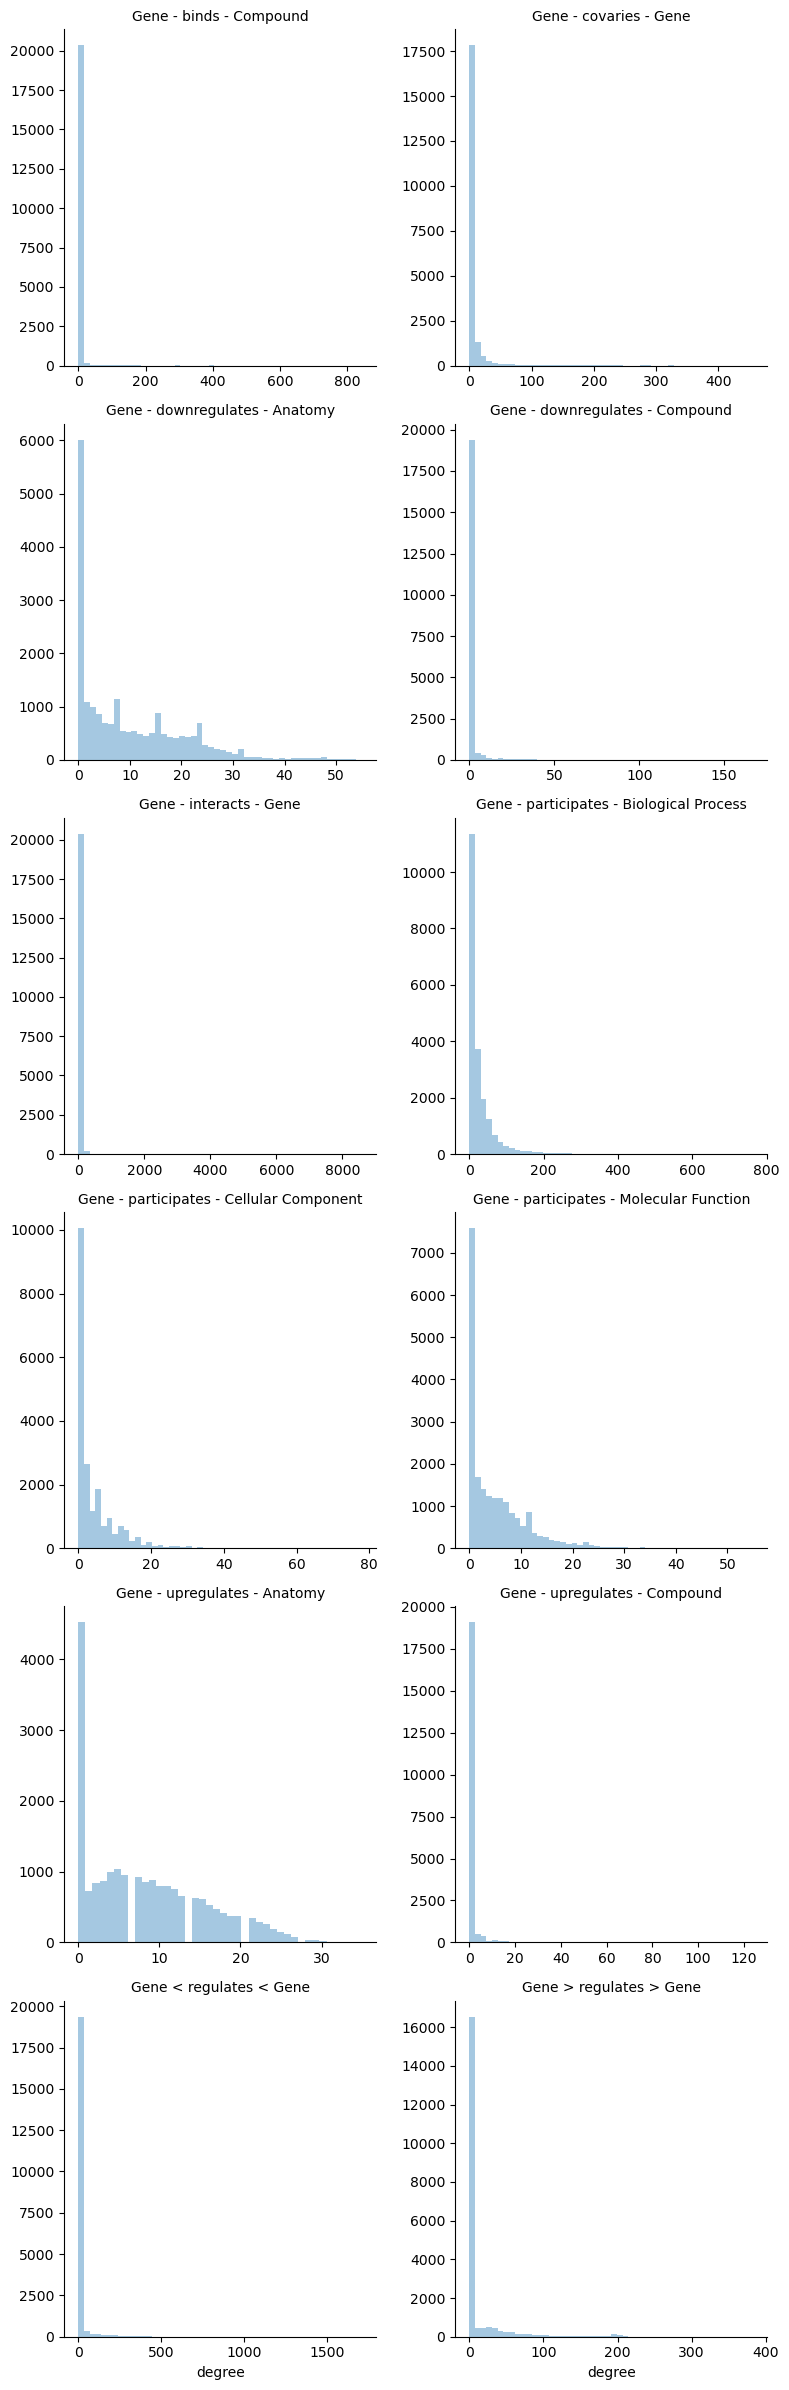

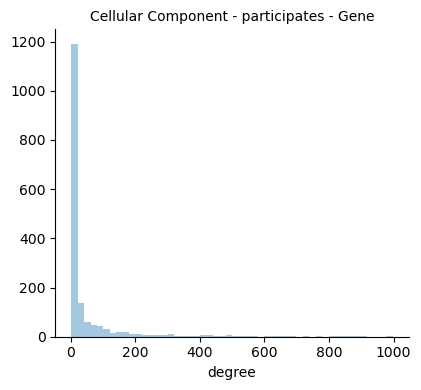

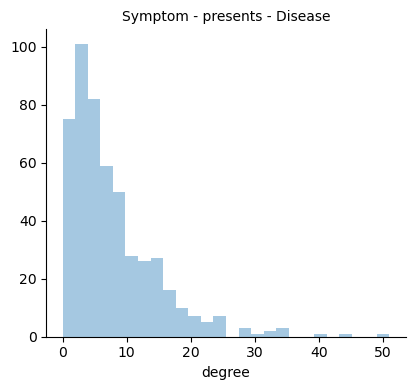

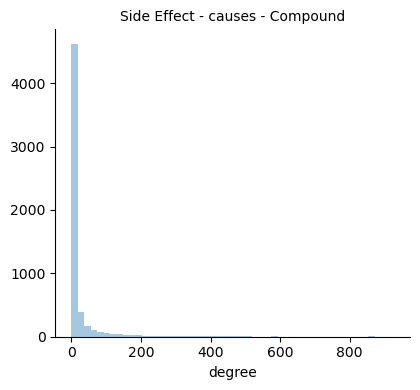

In [61]:
# Create and save degree distribution vizualizations
# Commented out due to https://github.com/ContinuumIO/anaconda-issues/issues/368
hetio.stats.plot_degrees(graph, os.path.join(path,'hetionet-custom-degrees.pdf'))

In [62]:
# Summary of metanodes and cooresponding nodes
metanode_df = hetio.stats.get_metanode_df(graph)
metanode_df.to_csv(os.path.join(path,'hetionet-custom-metanodes.tsv'), sep='\t', index=False)
metanode_df

/opt/anaconda3/lib/python3.9/site-packages/hetio/stats.py:80: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pandas.Series()
/opt/anaconda3/lib/python3.9/site-packages/hetio/stats.py:80: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pandas.Series()
/opt/anaconda3/lib/python3.9/site-packages/hetio/stats.py:80: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pandas.Series()
/opt/anaconda3/lib/python3.9/site-packages/hetio/stats.py:80: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pandas.Series()


,metanode,abbreviation,metaedges,nodes,unconnected_nodes
3,Anatomy,A,3,652,101
6,Biological Process,BP,1,12322,0
8,Cellular Component,CC,1,1695,0
2,Compound,C,7,2778,505
1,Disease,D,5,137,9
0,Gene,G,11,20608,1486
7,Molecular Function,MF,1,3460,0
5,Pharmacologic Class,PC,1,478,0
9,Side Effect,SE,1,5734,41
4,Symptom,S,1,505,35


In [63]:
# Total number of nodes
metanode_df.nodes.sum()

48369

In [64]:
# Summary of metaedges and cooresponding edges
metaedge_df = hetio.stats.get_metaedge_df(graph)

# Calculate number of unbiased edges
rows = list()
for metaedge, edges in graph.get_metaedge_to_edges(exclude_inverts=True).items():
    unbiased = sum(edge.data['unbiased'] for edge in edges)
    rows.append({'metaedge': str(metaedge), 'unbiased': unbiased})

metaedge_df = metaedge_df.merge(pandas.DataFrame(rows))
metaedge_df.to_csv(os.path.join(path,'hetionet-custom-metaedges.tsv'), sep='\t', index=False)
metaedge_df

/opt/anaconda3/lib/python3.9/site-packages/hetio/stats.py:97: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pandas.Series()
/opt/anaconda3/lib/python3.9/site-packages/hetio/stats.py:97: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pandas.Series()
/opt/anaconda3/lib/python3.9/site-packages/hetio/stats.py:97: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pandas.Series()
/opt/anaconda3/lib/python3.9/site-packages/hetio/stats.py:97: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pandas.Series()


,metaedge,abbreviation,edges,source_nodes,target_nodes,unbiased
0,Anatomy - downregulates - Gene,AdG,201798,64,15544,201798
1,Anatomy - upregulates - Gene,AuG,169742,64,16084,169742
2,Compound - binds - Gene,CbG,25733,2167,2705,0
3,Compound - causes - Side Effect,CcSE,138807,1073,5693,0
4,Compound - downregulates - Gene,CdG,21490,746,2839,21490
5,Compound - palliates - Disease,CpD,381,214,48,0
6,Compound - treats - Disease,CtD,748,383,76,0
7,Compound - upregulates - Gene,CuG,19062,715,3197,19062
8,Disease - localizes - Anatomy,DlA,4335,121,537,0
9,Disease - presents - Symptom,DpS,3758,121,470,0


In [62]:
# Summary of different styles for representing each metaedge
#metaedge_style_df = hetio.stats.get_metaedge_style_df(metagraph)
#metaedge_style_df.to_csv('data/summary/metaedge-styles.tsv', sep='\t', index=False)

In [65]:
# Number of edges in the network
metaedge_df.edges.sum()

1804289

## Save graph

In [54]:
#modify the functions to save properties of node and rel
#https://github.com/hetio/hetnetpy/blob/main/hetnetpy/readwrite.py
import collections
import operator
import pandas as pd

def write_nodetable(graph):
    """Write a tabular encoding of the graph nodes."""
    rows = list()
    for node in graph.node_dict.values():
        row = collections.OrderedDict()
        row["kind"] = node.metanode.identifier
        row["id"] = str(node)
        row["name"] = node.name
        row["sourceDB"] = node.data['source']
        rows.append(row)
    rows.sort(key=operator.itemgetter("kind", "id"))
    fieldnames = ["id", "name", "kind", "sourceDB"]
    df_nodes_tsv = pd.DataFrame(rows, columns=fieldnames)
    print(df_nodes_tsv.shape)
    return df_nodes_tsv


def write_edgetable(graph):
    """Write a tsv of the graph edges."""
    rows = list()
    edge_properties=["sourceDB", "unbiased", "affinity_nM", "z_score", "p_fisher", "correlation"]
    fieldnames =["source", "metaedge", "target"]
    fieldnames = fieldnames+edge_properties
    metaedge_to_edges = graph.get_metaedge_to_edges(exclude_inverts=True)
    for metaedge, edges in metaedge_to_edges.items():
        for edge in edges:
            row = collections.OrderedDict()
            row["source"] = edge.source
            row["metaedge"] = edge.metaedge.abbrev
            row["target"] = edge.target
            for pro in edge_properties:
                if pro =='sourceDB':
                    if 'source' in edge.data.keys():
                        row[pro]=edge.data['source']
                    else:
                        row[pro]=None
                else:
                    if pro in edge.data.keys():
                        row[pro]=edge.data[pro]
                    else:
                        row[pro]=None
            rows.append(row)
    df_edges_tsv = pd.DataFrame(rows, columns=fieldnames)
    print(df_edges_tsv.shape)
    return df_edges_tsv

In [71]:
# Write nodes to a table
#hetio.readwrite.write_nodetable(graph, os.path.join(path,'nodes.tsv'))
df_nodes_tsv = write_nodetable(graph)
df_nodes_tsv.to_csv(os.path.join(path,'hetionet-custom-nodes.tsv'), sep="\t", header=True, index=False) 

# Write edges to a table
#hetio.readwrite.write_sif(graph, os.path.join(path,'edges.sif.gz'))
df_edges_tsv = write_edgetable(graph)
df_edges_tsv.to_csv(os.path.join(path,'hetionet-custom-edges.tsv'), sep="\t", header=True, index=False) 

(48369, 4)
(1804289, 9)


In [56]:
df_edges_tsv.groupby('metaedge')["sourceDB","unbiased", "affinity_nM", "z_score", "p_fisher", "correlation"].nunique()#.add_prefix('num_').reset_index()

/var/folders/sg/983t9lp12bsfyjv9ylh6002m0000gt/T/ipykernel_91920/3904201155.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_edges_tsv.groupby('metaedge')["sourceDB","unbiased", "affinity_nM", "z_score", "p_fisher", "correlation"].nunique()#.add_prefix('num_').reset_index()


,sourceDB,unbiased,affinity_nM,z_score,p_fisher,correlation
metaedge,,,,,,
AdG,1,1,0,0,0,0
AuG,1,1,0,0,0,0
CbG,246,1,1720,0,0,0
CcSE,1,1,0,0,0,0
CdG,1,1,0,8568,0,0
CpD,1,1,0,0,0,0
CtD,1,1,0,0,0,0
CuG,1,1,0,8063,0,0
DlA,1,1,0,0,3732,0


In [67]:
#df_edges_tsv[['metaedge','sourceDB']].drop_duplicates()
#df_edges_tsv['sourceDB'].unique()

In [57]:
df_nodes_tsv[['kind','source']].drop_duplicates()

,kind,source
0,Anatomy,Uberon
652,Biological Process,Gene Ontology
12974,Cellular Component,Gene Ontology
14669,Compound,DrugBank
17447,Disease,Disease Ontology
17584,Gene,Entrez Gene
38192,Molecular Function,Gene Ontology
41652,Pharmacologic Class,FDA via DrugCentral
42130,Side Effect,Hetionet - UMLS via SIDER 4.1
47864,Symptom,MeSH


In [58]:
# Write graph as json
hetio.readwrite.write_graph(graph, os.path.join(path,'hetionet-custom-hetnet.json.bz2'))

#read graph
#graph = hetio.readwrite.read_graph(path, formatting=None)

## Barplots of metaedge and metanode counts

In [68]:
%matplotlib inline

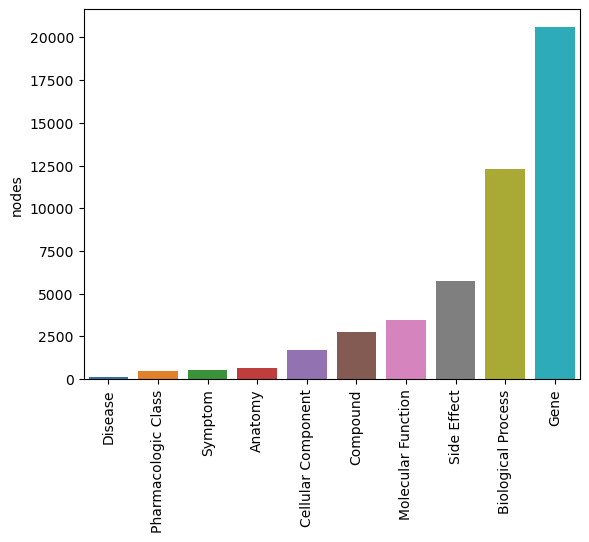

In [69]:
ax = seaborn.barplot(x='metanode', y='nodes', data=metanode_df.sort_values('nodes'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('nodes');

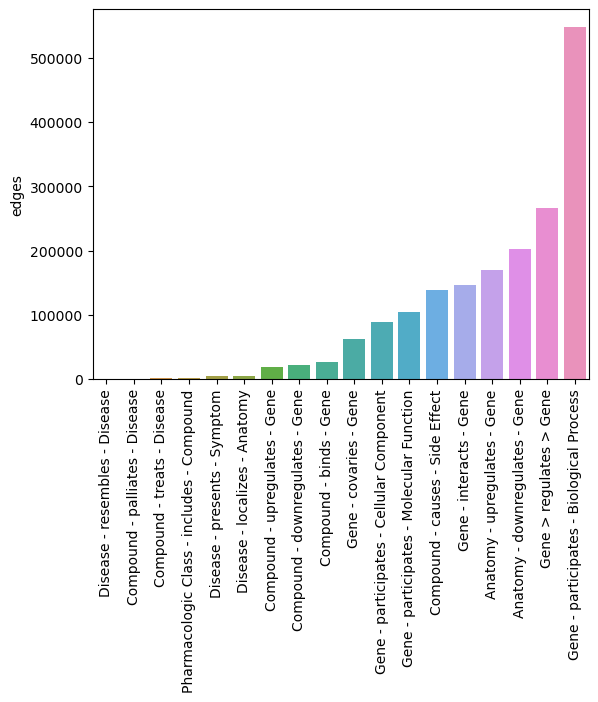

In [70]:
ax = seaborn.barplot(x='metaedge', y='edges', data=metaedge_df.sort_values('edges'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('edges');